<b> <font size="+2.5"> Severity of age effect across cell types
 </b> </font> <br>

Date: 2023-11-22 <br>
Author: ASF

In [ ]:
#Dreamlet on downsampled adata object
# downsampled to 5000 nuclei

Performing DE on 10 downsampled adata objects <b> takes ~29 hours </b>

# Set-up

In [1]:
# Load libraries
suppressPackageStartupMessages({
library(SingleCellExperiment)
library(zellkonverter)
library(dreamlet)
library(zenith)
library(DelayedArray)
library(GSEABase)
library(cowplot)
library(tidyverse)
library(kableExtra)
library(qvalue)
library(scattermore)
library(RColorBrewer)
library(corrplot)
library(viridis)
library(dplyr)
library(org.Hs.eg.db)
library(EnrichmentBrowser)
library(ggrepel)
library(rhdf5)
library(HDF5Array)
library(gridExtra)
library(grid)
library(readxl)
library(writexl)
})

# Run DE analysis in the downsampled data

In [2]:
# read in PC1_hidden_noise
PC1 <- read_xlsx(path = "../datasets/PC1_hidden_confounders.xlsx")

## downsample_1

In [3]:
file_1 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_1.h5ad"
sce_1 <- readH5AD(file_1, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_1$RIN[is.na(sce_1$RIN)] = median(sce_1$RIN, na.rm=TRUE) 

sce_1$Status <- as.factor(as.character(sce_1$Status))
sce_1$Status <- factor(sce_1$Status, c('0','1'))

sce_1$X6.Batch <- as.character(sce_1$X6.Batch)

sce_1$Disease_Status <- ifelse(sce_1$Status=='0', 'Controls', 'Cases')
sce_1$Disease_Status <- factor(sce_1$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_1 <- aggregateToPseudoBulk(sce_1,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_1$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_1 <- processAssays(pb_1, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_1 <- dreamlet(res.proc_1, form, BPPARAM = SnowParam(12))

df_de_Age_1 <- fit_1 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_1

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.5 mins

  Astro_PP...
3.4 mins

  Endothelial...
3.3 mins

  Exc_L2-3...
3.4 mins

  Exc_L3-5...
3.3 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.3 mins

  Exc_L4-6_3...
3.3 mins

  Exc_L5-6_1...
3.4 mins

  Exc_L5-6_2...
3.4 mins

  Exc_L5-6_HTR2C...
3.4 mins

  In_LAMP5_1...
3.3 mins

  In_LAMP5_2...
3.4 mins

  In_PVALB_Ba...
3.3 mins

  In_PVALB_Ch...
3.3 mins

  In_RELN...
3.4 mins

  In_SST...
3.4 mins

  In_VIP...
3.5 mins

  Microglia...
3.4 mins

  OPC...
3.3 mins

  Oligodendrocyte...
3.4 mins


Of 74,150 models fit across all assays, 0.00135% failed


  Astro_FB...
1.3 mins

  Astro_PP...
1.2 mins

  Endothelial...
44 secs

  Exc_L2-3...
5 mins

  Exc_L3-5...
5 mins

  Exc_L4-6_1...
5.7 mins

  Exc_L4-6_2...
4.9 mins

  Exc_L4-6_3...
5.5 mins

  Exc_

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,852,23,11,0.18887321
Astro_PP,864,10,4,0.23128786
Endothelial,576,4,1,0.05132639
Exc_L2-3,5060,177,93,0.27383999
Exc_L3-5,5205,100,55,0.16462667
Exc_L4-6_1,5866,183,91,0.26777589
Exc_L4-6_2,5065,193,109,0.27722338
Exc_L4-6_3,5730,98,45,0.15451563
Exc_L5-6_1,5097,79,46,0.21514053


In [4]:
summarized_n_DE <- list()
summarized_n_DE[['downsampled_1']] <- df_de_Age_1

In [5]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_1 <- fit_1 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_1 <- as.data.frame(DE_results_Age_1)

DE_res_Age_list_1 <- list()
for (celltype in assayNames(pb_1)){
    DE_res_Age_list_1[[celltype]] <- DE_results_Age_1[DE_results_Age_1$assay==celltype,] 
}

library(writexl)
write_xlsx(DE_res_Age_list_1, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled1_20231122.xlsx", 
           col_names = TRUE)

In [6]:
n_reads_list <- list()

In [7]:
n_reads_per_celltype_1 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_1))))
colnames(n_reads_per_celltype_1) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_1$celltype <- assayNames(pb_1)
for (celltype in assayNames(pb_1)){
    tmp <- as.data.frame(as.matrix(assay(pb_1, celltype)))
    n_reads_per_celltype_1[n_reads_per_celltype_1$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_1[[celltype]]$ID,]
    n_reads_per_celltype_1[n_reads_per_celltype_1$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_1$percent <- n_reads_per_celltype_1$n_reads_DE/n_reads_per_celltype_1$n_reads_total*100
n_reads_per_celltype_1 

n_reads_list[['downsampled_1']] <- n_reads_per_celltype_1

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7798673,3784217,48.52386
Astro_PP,8629979,4359990,50.52144
Endothelial,6626901,2091945,31.56747
Exc_L2-3,37286062,31577573,84.69002
Exc_L3-5,37846822,32221341,85.13619
Exc_L4-6_1,44147933,38617360,87.47263
Exc_L4-6_2,35268800,29896619,84.76789
Exc_L4-6_3,48879401,42898016,87.76297
Exc_L5-6_1,43009934,36878925,85.74513


In [11]:
# cell type order
ctorder <- c('Exc_L2-3','Exc_L3-5','Exc_L4-6_1','Exc_L4-6_2', 'Exc_L4-6_3', 'Exc_L5-6_1', 'Exc_L5-6_2', 'Exc_L5-6_HTR2C', 
            'In_LAMP5_1', 'In_LAMP5_2','In_PVALB_Ba','In_PVALB_Ch','In_RELN','In_SST','In_VIP','Astro_FB','Astro_PP','Endothelial',
            'Microglia','Oligodendrocyte', 'OPC')

## downsample_2

In [8]:
file_2 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_2.h5ad"
sce_2 <- readH5AD(file_2, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_2$RIN[is.na(sce_2$RIN)] = median(sce_2$RIN, na.rm=TRUE) 

sce_2$Status <- as.factor(as.character(sce_2$Status))
sce_2$Status <- factor(sce_2$Status, c('0','1'))

sce_2$X6.Batch <- as.character(sce_2$X6.Batch)

sce_2$Disease_Status <- ifelse(sce_2$Status=='0', 'Controls', 'Cases')
sce_2$Disease_Status <- factor(sce_2$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_2 <- aggregateToPseudoBulk(sce_2,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_2$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_2 <- processAssays(pb_2, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_2 <- dreamlet(res.proc_2, form, BPPARAM = SnowParam(12))

df_de_Age_2 <- fit_2 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_2

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.6 mins

  Astro_PP...
3.5 mins

  Endothelial...
3.5 mins

  Exc_L2-3...
3.6 mins

  Exc_L3-5...
3.5 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.5 mins

  Exc_L4-6_3...
3.5 mins

  Exc_L5-6_1...
3.5 mins

  Exc_L5-6_2...
3.5 mins

  Exc_L5-6_HTR2C...
3.5 mins

  In_LAMP5_1...
3.6 mins

  In_LAMP5_2...
3.4 mins

  In_PVALB_Ba...
3.5 mins

  In_PVALB_Ch...
3.5 mins

  In_RELN...
3.4 mins

  In_SST...
3.5 mins

  In_VIP...
3.6 mins

  Microglia...
3.6 mins

  OPC...
3.5 mins

  Oligodendrocyte...
3.6 mins

  Astro_FB...
1.3 mins

  Astro_PP...
1.1 mins

  Endothelial...
42 secs

  Exc_L2-3...
5 mins

  Exc_L3-5...
5.1 mins

  Exc_L4-6_1...
5.9 mins

  Exc_L4-6_2...
5.1 mins

  Exc_L4-6_3...
5.5 mins

  Exc_L5-6_1...
5.1 mins

  Exc_L5-6_2...
2 mins

  Exc_L5-6_HT

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,817,21,8,0.39162899
Astro_PP,780,13,5,0.10695567
Endothelial,555,9,1,0.20294962
Exc_L2-3,5134,196,112,0.30335120
Exc_L3-5,5221,95,43,0.17030659
Exc_L4-6_1,6100,147,67,0.22890474
Exc_L4-6_2,5230,226,136,0.25149536
Exc_L4-6_3,5657,89,41,0.20075794
Exc_L5-6_1,5135,91,39,0.22925479


In [9]:
summarized_n_DE[['downsampled_2']] <- df_de_Age_2

In [10]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_2 <- fit_2 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_2 <- as.data.frame(DE_results_Age_2)

DE_res_Age_list_2 <- list()
for (celltype in assayNames(pb_2)){
    DE_res_Age_list_2[[celltype]] <- DE_results_Age_2[DE_results_Age_2$assay==celltype,] 
}

write_xlsx(DE_res_Age_list_2, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled2_20231122.xlsx", 
           col_names = TRUE)

In [11]:
n_reads_per_celltype_2 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_2))))
colnames(n_reads_per_celltype_2) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_2$celltype <- assayNames(pb_2)
for (celltype in assayNames(pb_2)){
    tmp <- as.data.frame(as.matrix(assay(pb_2, celltype)))
    n_reads_per_celltype_2[n_reads_per_celltype_2$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_2[[celltype]]$ID,]
    n_reads_per_celltype_2[n_reads_per_celltype_2$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_2$percent <- n_reads_per_celltype_2$n_reads_DE/n_reads_per_celltype_2$n_reads_total*100
n_reads_per_celltype_2 

n_reads_list[['downsampled_2']] <- n_reads_per_celltype_2

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7785308,3709666,47.64957
Astro_PP,8473154,4120805,48.63366
Endothelial,6502484,2005062,30.83532
Exc_L2-3,37287009,31760446,85.17832
Exc_L3-5,37719922,32082896,85.05557
Exc_L4-6_1,44266091,39206233,88.56945
Exc_L4-6_2,35243993,30128391,85.48518
Exc_L4-6_3,49134820,42857477,87.22425
Exc_L5-6_1,43429248,37317138,85.92628


## downsample_3

In [12]:
file_3 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_3.h5ad"
sce_3 <- readH5AD(file_3, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_3$RIN[is.na(sce_3$RIN)] = median(sce_3$RIN, na.rm=TRUE) 

sce_3$Status <- as.factor(as.character(sce_3$Status))
sce_3$Status <- factor(sce_3$Status, c('0','1'))

sce_3$X6.Batch <- as.character(sce_3$X6.Batch)

sce_3$Disease_Status <- ifelse(sce_3$Status=='0', 'Controls', 'Cases')
sce_3$Disease_Status <- factor(sce_3$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_3 <- aggregateToPseudoBulk(sce_3,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_3$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_3 <- processAssays(pb_3, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_3 <- dreamlet(res.proc_3, form, BPPARAM = SnowParam(12))

df_de_Age_3 <- fit_3 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  

df_de_Age_3

summarized_n_DE[['downsampled_3']] <- df_de_Age_3

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.5 mins

  Astro_PP...
3.5 mins

  Endothelial...
3.4 mins

  Exc_L2-3...
3.5 mins

  Exc_L3-5...
3.5 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.5 mins

  Exc_L4-6_3...
3.5 mins

  Exc_L5-6_1...
3.5 mins

  Exc_L5-6_2...
3.6 mins

  Exc_L5-6_HTR2C...
3.4 mins

  In_LAMP5_1...
3.5 mins

  In_LAMP5_2...
3.4 mins

  In_PVALB_Ba...
3.5 mins

  In_PVALB_Ch...
3.6 mins

  In_RELN...
3.4 mins

  In_SST...
3.5 mins

  In_VIP...
3.5 mins

  Microglia...
3.5 mins

  OPC...
3.4 mins

  Oligodendrocyte...
3.6 mins


Of 74,847 models fit across all assays, 0.00802% failed


  Astro_FB...
1.1 mins

  Astro_PP...
1.3 mins

  Endothelial...
45 secs

  Exc_L2-3...
5.1 mins

  Exc_L3-5...
5.1 mins

  Exc_L4-6_1...
5.7 mins

  Exc_L4-6_2...
5 mins

  Exc_L4-6_3...
5.5 mins

  Ex

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,859,13,9,0.1871272
Astro_PP,883,16,6,0.3388534
Endothelial,589,1,0,0.0000000
Exc_L2-3,5197,183,102,0.3109989
Exc_L3-5,5160,80,32,0.2167714
Exc_L4-6_1,5863,228,116,0.3256276
Exc_L4-6_2,5104,180,85,0.2273524
Exc_L4-6_3,5629,107,40,0.1973755
Exc_L5-6_1,5242,95,41,0.1671985


In [13]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_3 <- fit_3 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_3 <- as.data.frame(DE_results_Age_3)

DE_res_Age_list_3 <- list()
for (celltype in assayNames(pb_3)){
    DE_res_Age_list_3[[celltype]] <- DE_results_Age_3[DE_results_Age_3$assay==celltype,] 
}

write_xlsx(DE_res_Age_list_3, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled3_20231122.xlsx", 
           col_names = TRUE)

In [14]:
n_reads_per_celltype_3 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_3))))
colnames(n_reads_per_celltype_3) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_3$celltype <- assayNames(pb_3)
for (celltype in assayNames(pb_3)){
    tmp <- as.data.frame(as.matrix(assay(pb_3, celltype)))
    n_reads_per_celltype_3[n_reads_per_celltype_3$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_3[[celltype]]$ID,]
    n_reads_per_celltype_3[n_reads_per_celltype_3$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_3$percent <- n_reads_per_celltype_3$n_reads_DE/n_reads_per_celltype_3$n_reads_total*100
n_reads_per_celltype_3 

n_reads_list[['downsampled_3']] <- n_reads_per_celltype_3

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7940989,3824009,48.15532
Astro_PP,8593478,4371495,50.86992
Endothelial,6577951,2092957,31.81777
Exc_L2-3,37097837,31723905,85.51416
Exc_L3-5,38053388,32269643,84.80097
Exc_L4-6_1,43719524,38305460,87.61637
Exc_L4-6_2,35021142,29724965,84.87720
Exc_L4-6_3,48944751,42662307,87.16421
Exc_L5-6_1,43310324,37382829,86.31390


## downsample 4

In [15]:
file_4 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_4.h5ad"
sce_4 <- readH5AD(file_4, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_4$RIN[is.na(sce_4$RIN)] = median(sce_4$RIN, na.rm=TRUE) 

sce_4$Status <- as.factor(as.character(sce_4$Status))
sce_4$Status <- factor(sce_4$Status, c('0','1'))

sce_4$X6.Batch <- as.character(sce_4$X6.Batch)

sce_4$Disease_Status <- ifelse(sce_4$Status=='0', 'Controls', 'Cases')
sce_4$Disease_Status <- factor(sce_4$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_4 <- aggregateToPseudoBulk(sce_4,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_4$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_4 <- processAssays(pb_4, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_4 <- dreamlet(res.proc_4, form, BPPARAM = SnowParam(12))

df_de_Age_4 <- fit_4 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_4

summarized_n_DE[['downsampled_4']] <- df_de_Age_4

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.5 mins

  Astro_PP...
3.5 mins

  Endothelial...
3.5 mins

  Exc_L2-3...
3.6 mins

  Exc_L3-5...
3.5 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.5 mins

  Exc_L4-6_3...
3.6 mins

  Exc_L5-6_1...
3.5 mins

  Exc_L5-6_2...
3.6 mins

  Exc_L5-6_HTR2C...
3.5 mins

  In_LAMP5_1...
3.4 mins

  In_LAMP5_2...
3.5 mins

  In_PVALB_Ba...
3.5 mins

  In_PVALB_Ch...
3.4 mins

  In_RELN...
3.5 mins

  In_SST...
3.6 mins

  In_VIP...
3.5 mins

  Microglia...
3.5 mins

  OPC...
3.4 mins

  Oligodendrocyte...
3.5 mins

  Astro_FB...
1.3 mins

  Astro_PP...
1.1 mins

  Endothelial...
48 secs

  Exc_L2-3...
5 mins

  Exc_L3-5...
5.2 mins

  Exc_L4-6_1...
5.8 mins

  Exc_L4-6_2...
5.1 mins

  Exc_L4-6_3...
5.5 mins

  Exc_L5-6_1...
5.1 mins

  Exc_L5-6_2...
1.9 mins

  Exc_L5-6_

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,766,19,10,0.28280995
Astro_PP,746,6,3,0.03260795
Endothelial,641,5,1,0.21616549
Exc_L2-3,5078,176,95,0.31453711
Exc_L3-5,5314,97,43,0.19297523
Exc_L4-6_1,5936,157,79,0.22262826
Exc_L4-6_2,5184,202,116,0.21289356
Exc_L4-6_3,5698,98,43,0.15981030
Exc_L5-6_1,5176,77,37,0.18787543


In [16]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_4 <- fit_4 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_4 <- as.data.frame(DE_results_Age_4)

DE_res_Age_list_4 <- list()
for (celltype in assayNames(pb_4)){
    DE_res_Age_list_4[[celltype]] <- DE_results_Age_4[DE_results_Age_4$assay==celltype,] 
}

write_xlsx(DE_res_Age_list_4, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled4_20231122.xlsx", 
           col_names = TRUE)

In [17]:
n_reads_per_celltype_4 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_4))))
colnames(n_reads_per_celltype_4) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_4$celltype <- assayNames(pb_4)
for (celltype in assayNames(pb_4)){
    tmp <- as.data.frame(as.matrix(assay(pb_4, celltype)))
    n_reads_per_celltype_4[n_reads_per_celltype_4$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_4[[celltype]]$ID,]
    n_reads_per_celltype_4[n_reads_per_celltype_4$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_4$percent <- n_reads_per_celltype_4$n_reads_DE/n_reads_per_celltype_4$n_reads_total*100
n_reads_per_celltype_4 

n_reads_list[['downsampled_4']] <- n_reads_per_celltype_4

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7775364,3565114,45.85141
Astro_PP,8475936,4068055,47.99535
Endothelial,6561210,2175298,33.15392
Exc_L2-3,37566097,31842936,84.76509
Exc_L3-5,37843184,32304644,85.36450
Exc_L4-6_1,44249717,38644676,87.33316
Exc_L4-6_2,34902067,28831357,82.60645
Exc_L4-6_3,48893642,42892355,87.72583
Exc_L5-6_1,43242447,37089693,85.77149


## downsample 5

In [18]:
file_5 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_5.h5ad"
sce_5 <- readH5AD(file_5, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_5$RIN[is.na(sce_5$RIN)] = median(sce_5$RIN, na.rm=TRUE) 

sce_5$Status <- as.factor(as.character(sce_5$Status))
sce_5$Status <- factor(sce_5$Status, c('0','1'))

sce_5$X6.Batch <- as.character(sce_5$X6.Batch)

sce_5$Disease_Status <- ifelse(sce_5$Status=='0', 'Controls', 'Cases')
sce_5$Disease_Status <- factor(sce_5$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_5 <- aggregateToPseudoBulk(sce_5,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_5$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_5 <- processAssays(pb_5, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_5 <- dreamlet(res.proc_5, form, BPPARAM = SnowParam(12))

df_de_Age_5 <- fit_5 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_5

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.5 mins

  Astro_PP...
3.5 mins

  Endothelial...
3.5 mins

  Exc_L2-3...
3.5 mins

  Exc_L3-5...
3.5 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.5 mins

  Exc_L4-6_3...
3.4 mins

  Exc_L5-6_1...
3.5 mins

  Exc_L5-6_2...
3.6 mins

  Exc_L5-6_HTR2C...
3.5 mins

  In_LAMP5_1...
3.4 mins

  In_LAMP5_2...
3.5 mins

  In_PVALB_Ba...
3.6 mins

  In_PVALB_Ch...
3.5 mins

  In_RELN...
3.5 mins

  In_SST...
3.6 mins

  In_VIP...
3.4 mins

  Microglia...
3.5 mins

  OPC...
3.5 mins

  Oligodendrocyte...
3.5 mins


Of 74,470 models fit across all assays, 0.00134% failed


  Astro_FB...
1.3 mins

  Astro_PP...
1.3 mins

  Endothelial...
48 secs

  Exc_L2-3...
5.2 mins

  Exc_L3-5...
5.3 mins

  Exc_L4-6_1...
5.6 mins

  Exc_L4-6_2...
5.2 mins

  Exc_L4-6_3...
5.8 mins

  

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,735,13,7,0.1703160
Astro_PP,799,12,5,0.0000000
Endothelial,624,8,2,0.3253436
Exc_L2-3,5247,198,112,0.2798045
Exc_L3-5,5309,118,42,0.1569057
Exc_L4-6_1,5759,165,70,0.2205084
Exc_L4-6_2,5267,167,96,0.2173614
Exc_L4-6_3,5988,113,50,0.2635929
Exc_L5-6_1,4759,81,37,0.2026220


In [19]:
summarized_n_DE[['downsampled_5']] <- df_de_Age_5

In [20]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_5 <- fit_5 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_5 <- as.data.frame(DE_results_Age_5)

DE_res_Age_list_5 <- list()
for (celltype in assayNames(pb_5)){
    DE_res_Age_list_5[[celltype]] <- DE_results_Age_5[DE_results_Age_5$assay==celltype,] 
}

write_xlsx(DE_res_Age_list_5, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled5_20231122.xlsx", 
           col_names = TRUE)

In [21]:
n_reads_per_celltype_5 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_5))))
colnames(n_reads_per_celltype_5) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_5$celltype <- assayNames(pb_5)
for (celltype in assayNames(pb_5)){
    tmp <- as.data.frame(as.matrix(assay(pb_5, celltype)))
    n_reads_per_celltype_5[n_reads_per_celltype_5$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_5[[celltype]]$ID,]
    n_reads_per_celltype_5[n_reads_per_celltype_5$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_5$percent <- n_reads_per_celltype_5$n_reads_DE/n_reads_per_celltype_5$n_reads_total*100
n_reads_per_celltype_5 

n_reads_list[['downsampled_5']] <- n_reads_per_celltype_5

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7818837,3582070,45.81334
Astro_PP,8504448,4178908,49.13791
Endothelial,6561588,2138099,32.58508
Exc_L2-3,37685041,32146203,85.30229
Exc_L3-5,37820080,32351650,85.54093
Exc_L4-6_1,43848531,38234624,87.19705
Exc_L4-6_2,35355743,30279219,85.64159
Exc_L4-6_3,49300057,43657294,88.55425
Exc_L5-6_1,43400047,36547208,84.21007


## downsample 6

In [22]:
file_6 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_6.h5ad"
sce_6 <- readH5AD(file_6, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_6$RIN[is.na(sce_6$RIN)] = median(sce_6$RIN, na.rm=TRUE) 

sce_6$Status <- as.factor(as.character(sce_6$Status))
sce_6$Status <- factor(sce_6$Status, c('0','1'))

sce_6$X6.Batch <- as.character(sce_6$X6.Batch)

sce_6$Disease_Status <- ifelse(sce_6$Status=='0', 'Controls', 'Cases')
sce_6$Disease_Status <- factor(sce_6$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_6 <- aggregateToPseudoBulk(sce_6,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_6$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_6 <- processAssays(pb_6, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_6 <- dreamlet(res.proc_6, form, BPPARAM = SnowParam(12))

df_de_Age_6 <- fit_6 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_6

summarized_n_DE[['downsampled_6']] <- df_de_Age_6

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.5 mins

  Astro_PP...
3.6 mins

  Endothelial...
3.5 mins

  Exc_L2-3...
3.5 mins

  Exc_L3-5...
3.6 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.6 mins

  Exc_L4-6_3...
3.6 mins

  Exc_L5-6_1...
3.5 mins

  Exc_L5-6_2...
3.7 mins

  Exc_L5-6_HTR2C...
3.4 mins

  In_LAMP5_1...
3.5 mins

  In_LAMP5_2...
3.4 mins

  In_PVALB_Ba...
3.6 mins

  In_PVALB_Ch...
3.5 mins

  In_RELN...
3.4 mins

  In_SST...
3.6 mins

  In_VIP...
3.5 mins

  Microglia...
3.4 mins

  OPC...
3.5 mins

  Oligodendrocyte...
3.5 mins

  Astro_FB...
1.1 mins

  Astro_PP...
1.3 mins

  Endothelial...
45 secs

  Exc_L2-3...
5.3 mins

  Exc_L3-5...
5.3 mins

  Exc_L4-6_1...
5.7 mins

  Exc_L4-6_2...
5 mins

  Exc_L4-6_3...
5.6 mins

  Exc_L5-6_1...
5 mins

  Exc_L5-6_2...
2.2 mins

  Exc_L5-6_HT

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,785,9,5,0.3295638
Astro_PP,850,13,1,0.1409348
Endothelial,591,5,2,0.3153958
Exc_L2-3,5300,185,101,0.3174315
Exc_L3-5,5375,103,42,0.2335054
Exc_L4-6_1,5817,162,76,0.2049917
Exc_L4-6_2,5089,209,123,0.2842063
Exc_L4-6_3,5741,106,46,0.1752939
Exc_L5-6_1,5010,92,42,0.2605501


In [23]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_6 <- fit_6 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_6 <- as.data.frame(DE_results_Age_6)

DE_res_Age_list_6 <- list()
for (celltype in assayNames(pb_6)){
    DE_res_Age_list_6[[celltype]] <- DE_results_Age_6[DE_results_Age_6$assay==celltype,] 
}

write_xlsx(DE_res_Age_list_6, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled6_20231122.xlsx", 
           col_names = TRUE)

In [24]:
n_reads_per_celltype_6 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_6))))
colnames(n_reads_per_celltype_6) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_6$celltype <- assayNames(pb_6)
for (celltype in assayNames(pb_6)){
    tmp <- as.data.frame(as.matrix(assay(pb_6, celltype)))
    n_reads_per_celltype_6[n_reads_per_celltype_6$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_6[[celltype]]$ID,]
    n_reads_per_celltype_6[n_reads_per_celltype_6$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_6$percent <- n_reads_per_celltype_6$n_reads_DE/n_reads_per_celltype_6$n_reads_total*100
n_reads_per_celltype_6 

n_reads_list[['downsampled_6']] <- n_reads_per_celltype_6

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7805766,3623680,46.42312
Astro_PP,8565426,4288259,50.06475
Endothelial,6482325,2065204,31.85900
Exc_L2-3,37210535,31899821,85.72793
Exc_L3-5,37837360,32400383,85.63067
Exc_L4-6_1,43840319,38442236,87.68694
Exc_L4-6_2,35089952,29737072,84.74526
Exc_L4-6_3,49034344,43077674,87.85205
Exc_L5-6_1,43200321,36917926,85.45753


## downsample 7

In [25]:
file_7 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_7.h5ad"
sce_7 <- readH5AD(file_7, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_7$RIN[is.na(sce_7$RIN)] = median(sce_7$RIN, na.rm=TRUE) 

sce_7$Status <- as.factor(as.character(sce_7$Status))
sce_7$Status <- factor(sce_7$Status, c('0','1'))

sce_7$X6.Batch <- as.character(sce_7$X6.Batch)

sce_7$Disease_Status <- ifelse(sce_7$Status=='0', 'Controls', 'Cases')
sce_7$Disease_Status <- factor(sce_7$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_7 <- aggregateToPseudoBulk(sce_7,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_7$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_7 <- processAssays(pb_7, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_7 <- dreamlet(res.proc_7, form, BPPARAM = SnowParam(12))

df_de_Age_7 <- fit_7 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_7

summarized_n_DE[['downsampled_7']] <- df_de_Age_7

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.5 mins

  Astro_PP...
3.6 mins

  Endothelial...
3.6 mins

  Exc_L2-3...
3.5 mins

  Exc_L3-5...
3.6 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.5 mins

  Exc_L4-6_3...
3.4 mins

  Exc_L5-6_1...
3.5 mins

  Exc_L5-6_2...
3.6 mins

  Exc_L5-6_HTR2C...
3.4 mins

  In_LAMP5_1...
3.6 mins

  In_LAMP5_2...
3.5 mins

  In_PVALB_Ba...
3.5 mins

  In_PVALB_Ch...
3.5 mins

  In_RELN...
3.5 mins

  In_SST...
3.5 mins

  In_VIP...
3.5 mins

  Microglia...
3.5 mins

  OPC...
3.5 mins

  Oligodendrocyte...
3.5 mins


Of 74,606 models fit across all assays, 0.00134% failed


  Astro_FB...
1.2 mins

  Astro_PP...
1.2 mins

  Endothelial...
46 secs

  Exc_L2-3...
5.2 mins

  Exc_L3-5...
5.1 mins

  Exc_L4-6_1...
5.9 mins

  Exc_L4-6_2...
5.1 mins

  Exc_L4-6_3...
5.8 mins

  

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,792,30,13,0.5068617
Astro_PP,822,10,2,0.3583242
Endothelial,574,9,4,0.3188201
Exc_L2-3,5289,191,87,0.3383532
Exc_L3-5,5180,81,35,0.1775594
Exc_L4-6_1,6017,159,73,0.2071627
Exc_L4-6_2,5207,200,111,0.3016078
Exc_L4-6_3,5951,120,48,0.2379124
Exc_L5-6_1,4942,89,38,0.2084998


In [26]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_7 <- fit_7 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_7 <- as.data.frame(DE_results_Age_7)

DE_res_Age_list_7 <- list()
for (celltype in assayNames(pb_7)){
    DE_res_Age_list_7[[celltype]] <- DE_results_Age_7[DE_results_Age_7$assay==celltype,] 
}

write_xlsx(DE_res_Age_list_7, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled7_20231122.xlsx", 
           col_names = TRUE)

In [27]:
n_reads_per_celltype_7 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_7))))
colnames(n_reads_per_celltype_7) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_7$celltype <- assayNames(pb_7)
for (celltype in assayNames(pb_7)){
    tmp <- as.data.frame(as.matrix(assay(pb_7, celltype)))
    n_reads_per_celltype_7[n_reads_per_celltype_7$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_7[[celltype]]$ID,]
    n_reads_per_celltype_7[n_reads_per_celltype_7$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_7$percent <- n_reads_per_celltype_7$n_reads_DE/n_reads_per_celltype_7$n_reads_total*100
n_reads_per_celltype_7 

n_reads_list[['downsampled_7']] <- n_reads_per_celltype_7

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7742159,3314814,42.81511
Astro_PP,8457212,4190521,49.54967
Endothelial,6591052,2073617,31.46109
Exc_L2-3,37690689,32205887,85.44786
Exc_L3-5,37639761,31952782,84.89103
Exc_L4-6_1,44258576,38946391,87.99739
Exc_L4-6_2,35112380,29944267,85.28122
Exc_L4-6_3,49110568,43475186,88.52511
Exc_L5-6_1,43097305,36739767,85.24841


## downsample 8

In [28]:
file_8 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_8.h5ad"
sce_8 <- readH5AD(file_8, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_8$RIN[is.na(sce_8$RIN)] = median(sce_8$RIN, na.rm=TRUE) 

sce_8$Status <- as.factor(as.character(sce_8$Status))
sce_8$Status <- factor(sce_8$Status, c('0','1'))

sce_8$X6.Batch <- as.character(sce_8$X6.Batch)

sce_8$Disease_Status <- ifelse(sce_8$Status=='0', 'Controls', 'Cases')
sce_8$Disease_Status <- factor(sce_8$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_8 <- aggregateToPseudoBulk(sce_8,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_8$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_8 <- processAssays(pb_8, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_8 <- dreamlet(res.proc_8, form, BPPARAM = SnowParam(12))

df_de_Age_8 <- fit_8 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_8

summarized_n_DE[['downsampled_8']] <- df_de_Age_8

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.6 mins

  Astro_PP...
3.7 mins

  Endothelial...
3.5 mins

  Exc_L2-3...
3.6 mins

  Exc_L3-5...
3.6 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.6 mins

  Exc_L4-6_3...
3.6 mins

  Exc_L5-6_1...
3.5 mins

  Exc_L5-6_2...
3.7 mins

  Exc_L5-6_HTR2C...
3.4 mins

  In_LAMP5_1...
3.4 mins

  In_LAMP5_2...
3.5 mins

  In_PVALB_Ba...
3.6 mins

  In_PVALB_Ch...
3.5 mins

  In_RELN...
3.5 mins

  In_SST...
3.5 mins

  In_VIP...
3.6 mins

  Microglia...
3.5 mins

  OPC...
3.5 mins

  Oligodendrocyte...
3.4 mins

  Astro_FB...
1.3 mins

  Astro_PP...
1.3 mins

  Endothelial...
49 secs

  Exc_L2-3...
5.1 mins

  Exc_L3-5...
5.2 mins

  Exc_L4-6_1...
5.7 mins

  Exc_L4-6_2...
5.1 mins

  Exc_L4-6_3...
5.5 mins

  Exc_L5-6_1...
5 mins

  Exc_L5-6_2...
1.9 mins

  Exc_L5-6_

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,813,14,4,0.12334285
Astro_PP,815,6,1,0.06248846
Endothelial,646,5,1,0.00000000
Exc_L2-3,5080,204,97,0.28861474
Exc_L3-5,5237,99,36,0.20815487
Exc_L4-6_1,5877,163,70,0.22500584
Exc_L4-6_2,5143,186,98,0.27704597
Exc_L4-6_3,5610,93,34,0.18196217
Exc_L5-6_1,4952,85,33,0.18172291


In [29]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_8 <- fit_8 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_8 <- as.data.frame(DE_results_Age_8)

DE_res_Age_list_8 <- list()
for (celltype in assayNames(pb_8)){
    DE_res_Age_list_8[[celltype]] <- DE_results_Age_8[DE_results_Age_8$assay==celltype,] 
}

library(writexl)
write_xlsx(DE_res_Age_list_8, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled8_20231122.xlsx", 
           col_names = TRUE)

In [30]:
n_reads_per_celltype_8 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_8))))
colnames(n_reads_per_celltype_8) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_8$celltype <- assayNames(pb_8)
for (celltype in assayNames(pb_8)){
    tmp <- as.data.frame(as.matrix(assay(pb_8, celltype)))
    n_reads_per_celltype_8[n_reads_per_celltype_8$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_8[[celltype]]$ID,]
    n_reads_per_celltype_8[n_reads_per_celltype_8$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_8$percent <- n_reads_per_celltype_8$n_reads_DE/n_reads_per_celltype_8$n_reads_total*100
n_reads_per_celltype_8 

n_reads_list[['downsampled_8']] <- n_reads_per_celltype_8

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7857126,3743823,47.64876
Astro_PP,8566435,4237572,49.46716
Endothelial,6577810,2188875,33.27665
Exc_L2-3,37555064,32002011,85.21357
Exc_L3-5,37618132,31880127,84.74670
Exc_L4-6_1,43992085,38690160,87.94800
Exc_L4-6_2,35142218,29957230,85.24570
Exc_L4-6_3,49159450,42986509,87.44302
Exc_L5-6_1,43172522,36789387,85.21482


In [32]:
write_xlsx(summarized_n_DE, path = "../results/dreamlet_tables/final_celltypes_N87/summarized_downsampled_1-8_DE_results_20231122.xlsx", 
           col_names = TRUE)

In [33]:
write_xlsx(n_reads_list, path = "../results/dreamlet_tables/final_celltypes_N87/n_reads_downsampled_1-8_20231122.xlsx", 
           col_names = TRUE)

## downsample 9

In [4]:
file_9 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_9.h5ad"
sce_9 <- readH5AD(file_9, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_9$RIN[is.na(sce_9$RIN)] = median(sce_9$RIN, na.rm=TRUE) 

sce_9$Status <- as.factor(as.character(sce_9$Status))
sce_9$Status <- factor(sce_9$Status, c('0','1'))

sce_9$X6.Batch <- as.character(sce_9$X6.Batch)

sce_9$Disease_Status <- ifelse(sce_9$Status=='0', 'Controls', 'Cases')
sce_9$Disease_Status <- factor(sce_9$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_9 <- aggregateToPseudoBulk(sce_9,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_9$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_9 <- processAssays(pb_9, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_9 <- dreamlet(res.proc_9, form, BPPARAM = SnowParam(12))

df_de_Age_9 <- fit_9 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_9

summarized_n_DE[['downsampled_9']] <- df_de_Age_9

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.5 mins

  Astro_PP...
3.3 mins

  Endothelial...
3.4 mins

  Exc_L2-3...
3.3 mins

  Exc_L3-5...
3.3 mins

  Exc_L4-6_1...
3.3 mins

  Exc_L4-6_2...
3.3 mins

  Exc_L4-6_3...
3.3 mins

  Exc_L5-6_1...
3.4 mins

  Exc_L5-6_2...
3.4 mins

  Exc_L5-6_HTR2C...
3.3 mins

  In_LAMP5_1...
3.4 mins

  In_LAMP5_2...
3.3 mins

  In_PVALB_Ba...
3.3 mins

  In_PVALB_Ch...
3.4 mins

  In_RELN...
3.3 mins

  In_SST...
3.3 mins

  In_VIP...
3.3 mins

  Microglia...
3.4 mins

  OPC...
3.4 mins

  Oligodendrocyte...
3.5 mins


Of 74,904 models fit across all assays, 0.00534% failed


  Astro_FB...
1.3 mins

  Astro_PP...
1.3 mins

  Endothelial...
1.1 mins

  Exc_L2-3...
5.3 mins

  Exc_L3-5...
5 mins

  Exc_L4-6_1...
5.7 mins

  Exc_L4-6_2...
5 mins

  Exc_L4-6_3...
5.7 mins

  Exc

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,836,30,18,0.3637507
Astro_PP,924,15,8,0.1516625
Endothelial,615,1,0,0.0000000
Exc_L2-3,5388,194,105,0.3235446
Exc_L3-5,5191,89,36,0.2372177
Exc_L4-6_1,5964,142,62,0.2789934
Exc_L4-6_2,5158,176,94,0.2819745
Exc_L4-6_3,5945,95,46,0.1193490
Exc_L5-6_1,4962,78,29,0.1906563


In [5]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_9 <- fit_9 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_9 <- as.data.frame(DE_results_Age_9)

DE_res_Age_list_9 <- list()
for (celltype in assayNames(pb_9)){
    DE_res_Age_list_9[[celltype]] <- DE_results_Age_9[DE_results_Age_9$assay==celltype,] 
}

write_xlsx(DE_res_Age_list_9, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled9_20231122.xlsx", 
           col_names = TRUE)

In [6]:
n_reads_per_celltype_9 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_9))))
colnames(n_reads_per_celltype_9) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_9$celltype <- assayNames(pb_9)
for (celltype in assayNames(pb_9)){
    tmp <- as.data.frame(as.matrix(assay(pb_9, celltype)))
    n_reads_per_celltype_9[n_reads_per_celltype_9$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_9[[celltype]]$ID,]
    n_reads_per_celltype_9[n_reads_per_celltype_9$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_9$percent <- n_reads_per_celltype_9$n_reads_DE/n_reads_per_celltype_9$n_reads_total*100
n_reads_per_celltype_9 

n_reads_list[['downsampled_9']] <- n_reads_per_celltype_9

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7745837,3722275,48.05517
Astro_PP,8601065,4427853,51.48029
Endothelial,6679482,2166958,32.44201
Exc_L2-3,37871634,32646958,86.20425
Exc_L3-5,37666647,32011244,84.98565
Exc_L4-6_1,43942880,38678513,88.01998
Exc_L4-6_2,35174708,30000510,85.29000
Exc_L4-6_3,49013068,43283945,88.31103
Exc_L5-6_1,43344794,36967959,85.28812


In [8]:
write_xlsx(summarized_n_DE, path = "../results/dreamlet_tables/final_celltypes_N87/summarized_downsampled_DE_results_9_20231122.xlsx", 
           col_names = TRUE)
write_xlsx(n_reads_list, path = "../results/dreamlet_tables/final_celltypes_N87/n_reads_downsampled_9_20231122.xlsx", 
           col_names = TRUE)

## downsample 10

In [4]:
file_10 <- "../datasets/adata_celltypes_after_manual_curation_downsampled_10.h5ad"
sce_10 <- readH5AD(file_10, use_hdf5=TRUE, verbose=FALSE)

#formating
# Set missing RIN to median
sce_10$RIN[is.na(sce_10$RIN)] = median(sce_10$RIN, na.rm=TRUE) 

sce_10$Status <- as.factor(as.character(sce_10$Status))
sce_10$Status <- factor(sce_10$Status, c('0','1'))

sce_10$X6.Batch <- as.character(sce_10$X6.Batch)

sce_10$Disease_Status <- ifelse(sce_10$Status=='0', 'Controls', 'Cases')
sce_10$Disease_Status <- factor(sce_10$Disease_Status, levels=c('Controls', 'Cases'))

#compute pseudobulk
# counts here should represent the raw counts
pb_10 <- aggregateToPseudoBulk(sce_10,
    assay = "counts",     
    cluster_id = "celltypes_final",  
    sample_id = "sample", 
    BPPARAM = SnowParam(6, progressbar=TRUE))

pb_10$PC1 <- PC1$PC1_hidden_noise

#Normalization
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
res.proc_10 <- processAssays(pb_10, form, min.count=10, min.prop=0.8, 
                                     min.cells=5, min.samples=61,BPPARAM = SnowParam(12))

# Differential Gene Expression Analysis
form <- ~ (1|X6.Batch) + (1|Sex) + (1|Disease_Status) + Age + PMI + RIN + Brain.pH + PC1
fit_10 <- dreamlet(res.proc_10, form, BPPARAM = SnowParam(12))

df_de_Age_10 <- fit_10 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay) %>% 
    summarise( 
      nGenes_tested = length(adj.P.Val), 
      nDE_0.1 = sum(adj.P.Val < 0.1),
        nDE_0.05 = sum(adj.P.Val < 0.05),
      pi1 = 1 - qvalue(P.Value)$pi0) %>%
mutate(assay = factor(assay))  
df_de_Age_10

summarized_n_DE[['downsampled_10']] <- df_de_Age_10

Warning message:
“'X' matrix does not support transposition and has been skipped”
Warning message:
“The names of these selected obs columns have been modified to match R
conventions: '6-Batch' -> 'X6.Batch'”
  Astro_FB...
3.6 mins

  Astro_PP...
3.3 mins

  Endothelial...
3.3 mins

  Exc_L2-3...
3.3 mins

  Exc_L3-5...
3.3 mins

  Exc_L4-6_1...
3.4 mins

  Exc_L4-6_2...
3.3 mins

  Exc_L4-6_3...
3.3 mins

  Exc_L5-6_1...
3.4 mins

  Exc_L5-6_2...
3.4 mins

  Exc_L5-6_HTR2C...
3.4 mins

  In_LAMP5_1...
3.4 mins

  In_LAMP5_2...
3.3 mins

  In_PVALB_Ba...
3.3 mins

  In_PVALB_Ch...
3.4 mins

  In_RELN...
3.4 mins

  In_SST...
3.4 mins

  In_VIP...
3.3 mins

  Microglia...
3.4 mins

  OPC...
3.4 mins

  Oligodendrocyte...
3.4 mins


Of 74,159 models fit across all assays, 0.0027% failed


  Astro_FB...
1.2 mins

  Astro_PP...
1.3 mins

  Endothelial...
60 secs

  Exc_L2-3...
4.8 mins

  Exc_L3-5...
5 mins

  Exc_L4-6_1...
5.5 mins

  Exc_L4-6_2...
4.9 mins

  Exc_L4-6_3...
5.5 mins

  Exc

assay,nGenes_tested,nDE_0.1,nDE_0.05,pi1
<fct>,<int>,<int>,<int>,<dbl>
Astro_FB,810,9,4,0.28963606
Astro_PP,986,6,1,0.09801503
Endothelial,552,9,2,0.38531611
Exc_L2-3,5124,202,105,0.27160873
Exc_L3-5,5196,89,34,0.17801564
Exc_L4-6_1,5743,168,82,0.22106443
Exc_L4-6_2,5035,214,107,0.28658132
Exc_L4-6_3,5668,124,55,0.21380321
Exc_L5-6_1,5007,87,37,0.16897633


In [5]:
# structure DE results in a list of dataframes
# each dataframe represents a cell type
DE_results_Age_10 <- fit_10 %>%
  topTable(coef='Age', number=Inf) %>%
    as_tibble %>% 
    group_by(assay)

DE_results_Age_10 <- as.data.frame(DE_results_Age_10)

DE_res_Age_list_10 <- list()
for (celltype in assayNames(pb_10)){
    DE_res_Age_list_10[[celltype]] <- DE_results_Age_10[DE_results_Age_10$assay==celltype,] 
}

write_xlsx(DE_res_Age_list_10, path = "../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_downsampled10_20231122.xlsx", 
           col_names = TRUE)

In [6]:
n_reads_per_celltype_10 <- as.data.frame(matrix(ncol=3, nrow=length(assayNames(pb_10))))
colnames(n_reads_per_celltype_10) <- c('celltype', 'n_reads_total', 'n_reads_DE')
n_reads_per_celltype_10$celltype <- assayNames(pb_10)
for (celltype in assayNames(pb_10)){
    tmp <- as.data.frame(as.matrix(assay(pb_10, celltype)))
    n_reads_per_celltype_10[n_reads_per_celltype_10$celltype == celltype,][2] <- tmp %>%  summarise_all(sum) %>% rowSums()
    #now extract counts for genes (rows) included in DE analysis
    tmp2 <- tmp[DE_res_Age_list_10[[celltype]]$ID,]
    n_reads_per_celltype_10[n_reads_per_celltype_10$celltype == celltype,][3] <- tmp2 %>%  summarise_all(sum) %>% rowSums()
}
n_reads_per_celltype_10$percent <- n_reads_per_celltype_10$n_reads_DE/n_reads_per_celltype_10$n_reads_total*100
n_reads_per_celltype_10 

n_reads_list[['downsampled_10']] <- n_reads_per_celltype_10

celltype,n_reads_total,n_reads_DE,percent
<chr>,<dbl>,<dbl>,<dbl>
Astro_FB,7691042,3646007,47.40589
Astro_PP,8598097,4540168,52.80434
Endothelial,6435790,1972303,30.64586
Exc_L2-3,37501928,31970122,85.24928
Exc_L3-5,37808947,32097752,84.89459
Exc_L4-6_1,43959051,38323056,87.17899
Exc_L4-6_2,34909078,29648587,84.93088
Exc_L4-6_3,49075488,43012912,87.64643
Exc_L5-6_1,43242127,36945705,85.43915


# extract number of DE genes for each downsample run 

In [7]:
write_xlsx(summarized_n_DE, path = "../results/dreamlet_tables/final_celltypes_N87/summarized_downsampled_1-10_DE_results_20231122.xlsx", 
           col_names = TRUE)

# extract number of reads for each downsample run

In [8]:
write_xlsx(n_reads_list, path = "../results/dreamlet_tables/final_celltypes_N87/n_reads_downsampled_1-10_20231122.xlsx", 
           col_names = TRUE)

# Fig. 2b - boxplot

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(readr)
library(readxl)
library(ggpubr)
library(rstatix)
library(writexl)
})

In [2]:
downsample_runs <- c("downsampled_1", "downsampled_2", "downsampled_3", "downsampled_4", "downsampled_5", "downsampled_6", 
                     "downsampled_7", "downsampled_8", "downsampled_9", "downsampled_10")

n_DE_genes_per_downsample_run <- list()
for (i in downsample_runs){
  n_DE_genes_per_downsample_run[[i]] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/summarized_downsampled_1-10_DE_results_20231122.xlsx', sheet = i))
}

n_DE_genes_all <- bind_rows(n_DE_genes_per_downsample_run)
#n_DE_genes_all

In [3]:
# get median DE genes to specify order
median_DE_genes <- n_DE_genes_all %>%
  group_by(assay) %>%
  dplyr::summarize(Median = median(`nDE_0.05`, na.rm=TRUE))

median_DE_genes <- as.data.frame(median_DE_genes)
median_DE_genes <- median_DE_genes[order(-median_DE_genes$Median),]
median_DE_genes$assay
n_DE_genes_all$assay <- factor(n_DE_genes_all$assay, levels=median_DE_genes$assay)


[1] "In_LAMP5_2"      "Exc_L4-6_2"      "Exc_L2-3"        "Exc_L4-6_1"     
 [5] "In_LAMP5_1"      "In_PVALB_Ch"     "Exc_L4-6_3"      "Exc_L3-5"       
 [9] "Exc_L5-6_1"      "In_VIP"          "Exc_L5-6_HTR2C"  "In_SST"         
[13] "In_PVALB_Ba"     "In_RELN"         "OPC"             "Astro_FB"       
[17] "Exc_L5-6_2"      "Astro_PP"        "Endothelial"     "Microglia"      
[21] "Oligodendrocyte"

In [4]:
library(plyr) 
# only load this libary here: see the package start-up message

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:rstatix’:

    desc, mutate


The following object is masked from ‘package:ggpubr’:

    mutate


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact




In [5]:
# define outlier function - so that outliers can then be plotted using boxplot
id_outliers <- function(x){
  q <- quantile(x,c(0.25,0.75))
  iqr <- abs(diff(q))
  ifelse((x < q[1] - 1.5*iqr) | (x > q[2] + 1.5*iqr),'Outlier','NotOutlier')
}

#ddply: Split data frame, apply function, and return results in a data frame
n_DE_genes_all <- as.data.frame(ddply(n_DE_genes_all,
                                  .(assay),
                                  transform,
                                  Outlier = id_outliers(nDE_0.05)))

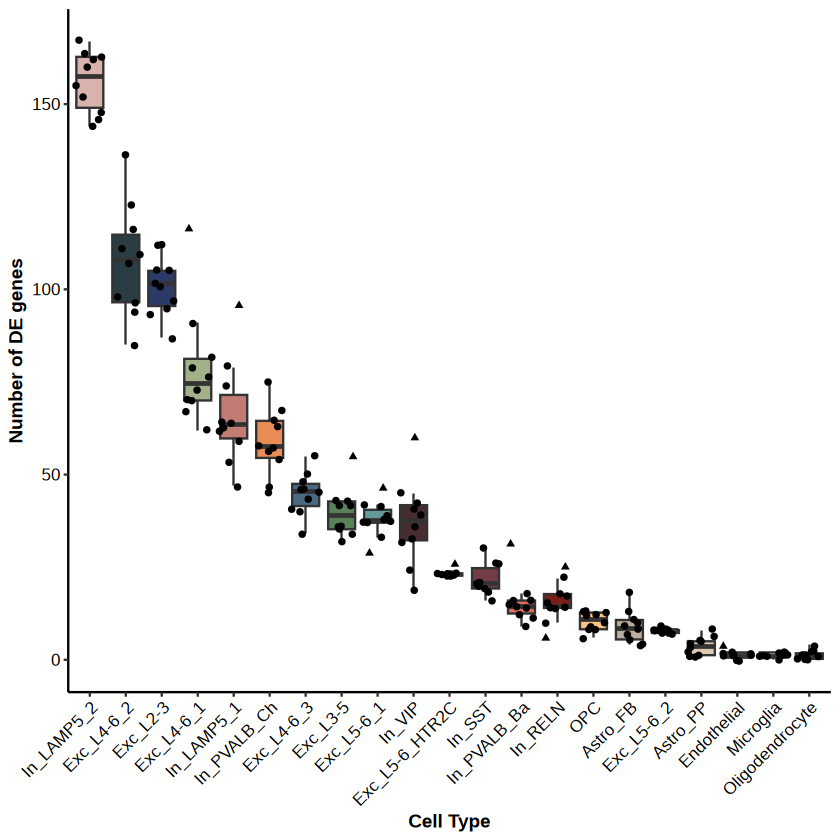

In [6]:
ggplot(n_DE_genes_all, aes(x=assay, y=nDE_0.05, fill=assay)) + 
 geom_boxplot(outlier.color=NA) + 
geom_point(aes(colour = assay,shape = Outlier),position = "jitter", colour='black')  +
theme_classic() + theme(legend.position = 'none')+ ylab('Number of DE genes') + xlab('Cell Type') +
  theme(axis.text.x = element_text(angle = 45, vjust=1, hjust=1, color='black', size=10), 
        axis.text.y = element_text(color='black',size=10), axis.title.y = element_text(face='bold', size=11), 
        axis.title.x=element_text(face='bold', size=11)) +
scale_fill_manual(values=c('#dab2ad','#2A3D45','#2B3A67','#A3B18A','#C17C74','#EA8C55', '#496A81', 
                           '#588157', '#66999B', '#472D30', '#727D71', '#723D46', '#E26D5C', 
                           '#781F19', '#FFC482', '#BCAC9B', '#748b97', '#DDC9B4', '#6e4c3c', 
                           '#FFE1A8', '7A6C5D'))

In [7]:
#ggsave('../figures/boxplot_downsampled_DE.pdf', plot = last_plot(), height =5 , width =5)

In [8]:
stat.test <- n_DE_genes_all %>%
  wilcox_test(`nDE_0.05` ~ assay) %>%
# adjust p-val using fdr (BH) across all comparisons
  adjust_pvalue(method = "BH") %>%
  add_significance()

In [9]:
head(stat.test)

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
nDE_0.05,In_LAMP5_2,Exc_L4-6_2,10,10,100,1.08e-05,0.000245,***
nDE_0.05,In_LAMP5_2,Exc_L2-3,10,10,100,1.81e-04,0.000245,***
nDE_0.05,In_LAMP5_2,Exc_L4-6_1,10,10,100,1.82e-04,0.000245,***
nDE_0.05,In_LAMP5_2,In_LAMP5_1,10,10,100,1.82e-04,0.000245,***
nDE_0.05,In_LAMP5_2,In_PVALB_Ch,10,10,100,1.08e-05,0.000245,***
nDE_0.05,In_LAMP5_2,Exc_L4-6_3,10,10,100,1.82e-04,0.000245,***


In [10]:
#stat.test[1:20,] # In_LAMP5_2 p< 0.0003
#stat.test[21:39,] # ns Exc_L4-6_2 vs Exc_L2-3; p < 0.003
#stat.test[40:57,] # Exc_L2-3 p< 0.005
#stat.test[58:74,] # ns Exc_L4-6_1 vs In_LAMP5_1; p < 0.003
#stat.test[75:90,] # ns In_LAMP5_1 vs In_PVALB_Ch; p < 0.006
#stat.test[91:105,] # In_PVALB_Ch; p < 0.003
#stat.test[106:119,] # ns Exc_L4-6_3 vs Exc_L3-5; p < 0.04
#stat.test[120:132,] # ns Exc_L3-5 vs Exc_L5-6_1 & In_VIP; p < 0.0003
#stat.test[133:144,] # ns Exc_L5-6_1 vs In_VIP; p < 0.0004
#stat.test[145:155,] # In_VIP; p < 0.004
#stat.test[156:165,] # ns Exc_L5-6_HTR2C vs In_SST; p < 0.003
#stat.test[166:174,] # In_SST p < 0.02
#stat.test[175:182,] # ns In_PVALB_Ba vs In_RELN, p < 0.02
#stat.test[183:189,] # In_RELN p < 0.02
#stat.test[190:195,] # ns OPC vs Astro_FB, p < 0.02
#stat.test[196:200,] # ns Astro_FB vs Exc_L5-6_2; p < 0.007
#stat.test[201:204,] # Exc_L5-6_2 p < 0.001
#stat.test[205:207,] # Astro_PP < 0.04
#stat.test[208:209,] # Endothelial ns
stat.test[210,] # Microglia ns

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
nDE_0.05,Microglia,Oligodendrocyte,10,10,58.5,0.518,0.5332353,ns


## Supplementary Table 7

In [11]:
library(writexl)
write_xlsx(stat.test, path = "../results/dreamlet_tables/final_celltypes_N87/stats_pairwise_wilcox_test_nDEgenes.xlsx", 
           col_names = TRUE)

# Session Info

In [12]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gridExtra_2.3               HDF5Array_1.30.0           
 [3] rhdf5_2.46.0                ggrepel_0.9.4              
 [5] EnrichmentBrowser_2.32.0    org.Hs.eg.db_3.18.0        
 [7]